# Malicious Smart Contract Detection Training Dataset Collection Notebook

This notebook collects smart contract creation bytecode and decompiled opcodes for malicious contract classification. 
Benign contracts are gathered from Luabase and malicious contracts from [Forta Network's labelled datasets github repo]("https://github.com/forta-network/labelled-datasets"). 

In [1]:
import logging
from os import environ

from evmdasm import EvmBytecode
import pandas as pd
from tqdm import tqdm
import requests
from web3 import Web3

tqdm.pandas()
# disable warning logs from evmdasm tool
logging.getLogger("evmdasm").setLevel(logging.CRITICAL)

In [7]:
LUABASE_API_KEY = environ['LUABASE_API_KEY']
LUABASE_QUERY_URL = "https://q.luabase.com/run"

def get_luabase_data(sql: str, limit: int = 1_000_000) -> pd.DataFrame:
    payload = {
        "block": {
            "details": {
                "sql": sql,
                "limit": limit,
                "parameters": {}
            }
        },
        "api_key": LUABASE_API_KEY,
    }
    headers = {"content-type": "application/json"}
    response = requests.request("POST", LUABASE_QUERY_URL, json=payload, headers=headers)
    data = response.json()
    return pd.DataFrame(data['data'])

In [2]:
w3_eth = Web3(Web3.HTTPProvider(environ["ALCHEMY_TRACE_API"]))
TRACES = {}

def get_created_contracts(tx_hash):
    if TRACES.get(tx_hash, 'error') != 'error':
        return TRACES[tx_hash]
    try:
        trace = w3_eth.parity.trace_transaction(tx_hash)
        result = [t for t in trace if t['type'].startswith('create')]
        TRACES[tx_hash] = result
        return result
    except:
        TRACES[tx_hash] = 'error'
        return []    

In [18]:
def get_creation_bytecode(row) -> str:
    """Get contract creation bytecode from EVM trace."""
    tx_hash = row['contract_creation_tx']
    contracts = get_created_contracts(tx_hash)
    
    if len(contracts) == 0:
        return

    for c in contracts:
        if c['result'] is not None and c['result'].get('address') == contract_addr:
            return c['action'].get('init')

def get_opcodes(row) -> str:
    bytecode = row['creation_bytecode']
    if bytecode is None:
        return ''

    try:
        opcodes = EvmBytecode(bytecode).disassemble()
    except Exception:
        return ''
    
    return " ".join([str(op).strip() for op in opcodes])

In [4]:
def get_malicious_contracts() -> pd.DataFrame:
    """Collects malicious contracts from Forta's labelled dataset github repo and its decompiled opcodes."""
    # csv from https://github.com/forta-network/labelled-datasets
    github_url = 'https://raw.githubusercontent.com/forta-network/labelled-datasets/main/labels/1/malicious_smart_contracts.csv'
    malicious = pd.read_csv(github_url)
    # exclude phishing hack related contracts
    malicious = malicious[malicious['contract_creator_etherscan_label'] != 'phish-hack']
    malicious['creation_bytecode'] = malicious.progress_apply(get_creation_bytecode, axis=1)
    malicious['decompiled_opcodes'] = malicious['creation_bytecode'].progress_apply(get_opcodes)
    return malicious

In [16]:
CONTRACT_DATA = {}

def get_contract_transactions(contracts):
    """Get contract transaction info from Etherscan."""
    
    # Etherscan API can take up to 5 contract addresses at a time.
    for i in range(0, len(contracts), 5):
        url = f"https://api.etherscan.io/api?module=contract&action=getcontractcreation&contractaddresses={','.join(contracts[i:i+5])}&apikey={environ['ETHERSCAN_API_KEY']}"
        resp = requests.get(url)
        data = resp.json()['result']
        for r in data:
            contract = r['contractAddress']
            CONTRACT_DATA[contract.lower()] = r

In [46]:
def get_contract_data(row):
    address = row['contract_address'].lower()
    data = CONTRACT_DATA.get(address)
    if data:
        return data.get('contractCreator'), data.get('txHash')
    
    return None, None

In [3]:
verified_contracts_sql = '''
SELECT abis.address as contract_address, 
       abis.name as contract_name,
       tags.label as contract_etherscan_label, 
       tags.tag as contract_tag
FROM ethereum.abis abis LEFT JOIN ethereum.tags tags ON tags.address = abis.address
'''

mev_contracts_sql = '''
SELECT tags.address as contract_address, 
       tags.label as contract_etherscan_label, 
       tags.tag as contract_tag 
FROM ethereum.tags tags WHERE tags.label = 'mev-bot'
'''

def get_benign_contracts() -> pd.DataFrame:
    """Collects verified and mev contracts from Luabase and its decompiled opcodes."""
    
    verified_contracts = get_luabase_data(verified_contracts_sql)
    mev_contracts = get_luabase_data(mev_contracts_sql)
    benign = pd.concat([verified_contracts, mev_contracts])
    
    get_contract_transactions(list(benign['contract_address']))
    
    benign[['contract_creator', 'contract_creation_tx']] = benign.apply(get_contract_data, axis=1, result_type='expand')
    benign['creation_bytecode'] = benign.progress_apply(get_creation_bytecode, axis=1)
    benign['decompiled_opcodes'] = benign['creation_bytecode'].progress_apply(get_opcodes, axis=1)
    return benign

In [10]:
malicious_contracts = get_malicious_contracts()
malicious_contracts['malicious'] = True

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:08<00:00, 19.32it/s]


In [64]:
benign_contracts = get_benign_contracts()
benign_contracts['malicious'] = False

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 140533/140533 [5:17:13<00:00,  7.38it/s]


In [51]:
dataset = pd.concat([malicious_contracts, benign_contracts])

In [55]:
dataset = dataset[(dataset['decompiled_opcodes'].notna()) & (dataset['decompiled_opcodes'] != '')]
dataset.drop_duplicates('contract_address', inplace=True)

In [56]:
dataset['malicious'].value_counts()

False    139451
True        149
Name: malicious, dtype: int64

In [57]:
dataset.to_parquet('malicious_contract_training_dataset_latest.parquet', index=None)

<AxesSubplot:ylabel='malicious'>

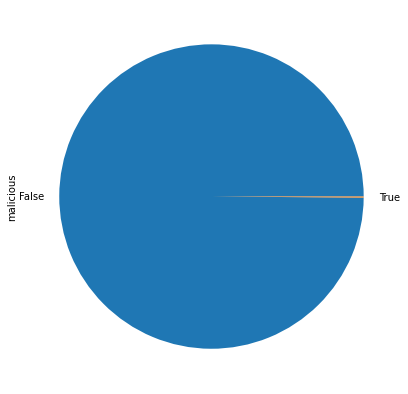

In [58]:
dataset['malicious'].value_counts().plot(kind='pie', figsize=(7, 7))